In [1]:
cd ..

/home/cody/RepDistiller


In [2]:
import pickle
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from src.analytics import df_builder
import numpy as np
import itertools
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from typing import Optional

In [3]:
%config InlineBackend.figure_format = 'retina'

In [4]:
with open('dfs.pickle', 'rb') as f:
    dfs = pickle.load(f)

In [5]:
with open('dfs_bias.pickle', 'rb') as f:
    dfs_bias = pickle.load(f)

In [6]:
pies = dfs.PIEs.drop(dfs.PIEs[dfs.PIEs.sparsity == 90].index)
pruning_stats = dfs.pruning_stats.drop(dfs.pruning_stats[dfs.pruning_stats.sparsity == 90].index)

bias_pies = dfs_bias.PIEs
bias_pruning_stats = dfs_bias.pruning_stats

In [7]:
dfs_bias.PIEs

,PIEs,method,sparsity,block1,block2,block3,fc
0,887.0,Struct Pruning,45.0,0.127235,0.267909,0.580583,0.260898
1,838.0,SP,45.0,0.112922,0.239923,0.534529,0.187294
2,768.0,SP + KD,45.0,0.107307,0.230820,0.537505,0.160958
3,770.0,KD,45.0,0.106282,0.230044,0.540483,0.160435
4,909.0,AT,45.0,0.044124,0.104296,0.474707,0.142481
5,742.0,AT + KD,45.0,0.051103,0.121364,0.480447,0.122170
6,881.0,PKT,45.0,0.074941,0.166586,0.506399,0.153504
7,748.0,PKT + KD,45.0,0.071161,0.164073,0.495360,0.127615
8,877.0,FSP,45.0,0.045392,0.162205,0.507827,0.171032
9,742.0,FSP + KD,45.0,0.062631,0.186946,0.514077,0.156224


In [8]:
pruning_stats = pruning_stats.rename(columns={"accuracy": "Accuracy", "sparsity": "Sparsity"})
pies = pies.rename(columns={"sparsity": "Sparsity"})
bias_pruning_stats = bias_pruning_stats.rename(columns={"accuracy": "Accuracy", "sparsity": "Sparsity"})
bias_pies = bias_pies.rename(columns={"sparsity": "Sparsity"})

In [9]:
methods = []
for method in dfs.PIEs['method']:
    if method not in methods:
        methods.append(method)
num_methods = len(methods)
sns.set_palette(sns.color_palette("husl", num_methods))
line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1, 1, 1)), (0, (5, 1)), 'dotted']

In [10]:
colors = sns.color_palette()

In [12]:
methods

['Struct Pruning',
 'SP',
 'KD',
 'AT',
 'PKT',
 'CRD',
 'FSP',
 'PKT + KD',
 'SP + KD',
 'FSP + KD',
 'AT + KD']

In [14]:
method_colors = {method: color for method, color in zip(methods, colors)}

In [15]:
markers = ['o', 'v', '^', '<', '>', 's', 'p', 'P', 'h', 'X', 'd']
method_markers = {method: marker for method, marker in zip(methods, markers)}

In [16]:
labels, teacher_pred = dfs.ground_labels, dfs.teacher_pred

In [17]:
teacher_conf = confusion_matrix(labels, teacher_pred)
diag = np.diag(teacher_conf)

FP_t = teacher_conf.sum(axis=0) - np.diag(teacher_conf)
FN_t = teacher_conf.sum(axis=1) - np.diag(teacher_conf)
TP_t = np.diag(teacher_conf)
TN_t = teacher_conf.sum() - (FP_t + FN_t + TP_t)

FPR_t = FP_t / (FP_t + TN_t)
FNR_t = FN_t / (FN_t + TP_t)

In [18]:
def dis_from_sym(p):
    return np.mean(np.abs(p[:, 0] - p[:, 1]) / np.sqrt(2))

In [19]:
def return_compression_errors(df, method, sparsity):
    
    classes = 100
    
    # get method stats
    meth_stats = df[np.logical_and(df.method==method, df.Sparsity==sparsity)]
    mean_FPR = meth_stats.FP_r.mean(axis=0)
    mean_FNR = meth_stats.FN_r.mean(axis=0)
    FPR_change = (mean_FPR - FPR_t)/FPR_t * 100
    FNR_change = (mean_FNR - FNR_t)/FNR_t * 100
    
    # make class points
    points = np.dstack((FPR_change, FNR_change))[0]
    
    # make centriod points
    centriods = np.empty((classes, 2))
    centriods[:,0].fill(np.mean(FPR_change))
    centriods[:,1].fill(np.mean(FNR_change))
    
    return mean_squared_error(points, centriods), dis_from_sym(points)

In [20]:
def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [21]:
def plot_dis(methods: list, df, sparsity, f_min: Optional[float] = None, f_max: Optional[float] = None):
    sns.set(style="ticks")
    error_dict = {'Normalized FPR Change': [], 'Normalized FNR Change': [], 'Method': []}
    for method in methods:
        stats = df[np.logical_and(df.method==method, df.Sparsity==sparsity)]
        mean_FPR = stats.FP_r.mean(axis=0)
        mean_FNR = stats.FN_r.mean(axis=0)
        FPR_change = (mean_FPR - FPR_t)/FPR_t * 100
        FNR_change = (mean_FNR - FNR_t)/FNR_t * 100
        for i in range(len(FPR_change)):
            error_dict['Normalized FPR Change'].append(FPR_change[i])
            error_dict['Normalized FNR Change'].append(FNR_change[i])
            error_dict['Method'].append(method)
    
    error_type_df = pd.DataFrame(error_dict)
    order = []
    for method in method_colors.keys():
        if method in np.unique(error_type_df['Method']):
            order.append(method)
    pallete = [method_colors[method] for method in order]
    markers = [method_markers[method] for method in order]
    sns.set_palette(pallete)
    f, ax = plt.subplots(figsize=(5, 5))
    if f_max is None:
        f_min = min(itertools.chain(error_type_df['Normalized FNR Change'], error_type_df['Normalized FPR Change']))
        f_max = max(itertools.chain(error_type_df['Normalized FNR Change'], error_type_df['Normalized FPR Change']))
    for i, method in enumerate(order):
        meth_df = error_type_df[error_type_df.Method == method]
        confidence_ellipse(meth_df['Normalized FNR Change'], meth_df['Normalized FPR Change'], ax, edgecolor=pallete[i])
        #confidence_ellipse(meth_df['Normalized FNR Change'], meth_df['Normalized FPR Change'], ax, n_std=2, edgecolor=pallete[i], linestyle='dashed')
        
    ax.set_xlim(f_min - f_max*.08, f_max + f_max*.08)
    ax.set_ylim(f_min - f_max*.08, f_max + f_max*.08)
    sns.scatterplot(data=error_type_df, x="Normalized FNR Change", y="Normalized FPR Change", hue="Method",hue_order=order, s=22, color=".15", style='Method', markers=method_markers)
    plt.grid()
    plt.title(f'{sparsity}% Sparsity')
    sns.set_palette(sns.color_palette("colorblind", num_methods))
    return f_min, f_max

In [22]:
method_markers

{'Struct Pruning': 'o',
 'SP': 'v',
 'KD': '^',
 'AT': '<',
 'PKT': '>',
 'CRD': 's',
 'FSP': 'p',
 'PKT + KD': 'P',
 'SP + KD': 'h',
 'FSP + KD': 'X',
 'AT + KD': 'd'}

In [23]:
pairs = list(itertools.chain((-52.38095238095239, 193.75000000000003), (-52.38095238095239, 144.44444444444443), (-50.0, 174.99999999999994)))
min_v = min(pairs)
max_v = max(pairs)

(-52.38095238095239, 193.75000000000003)

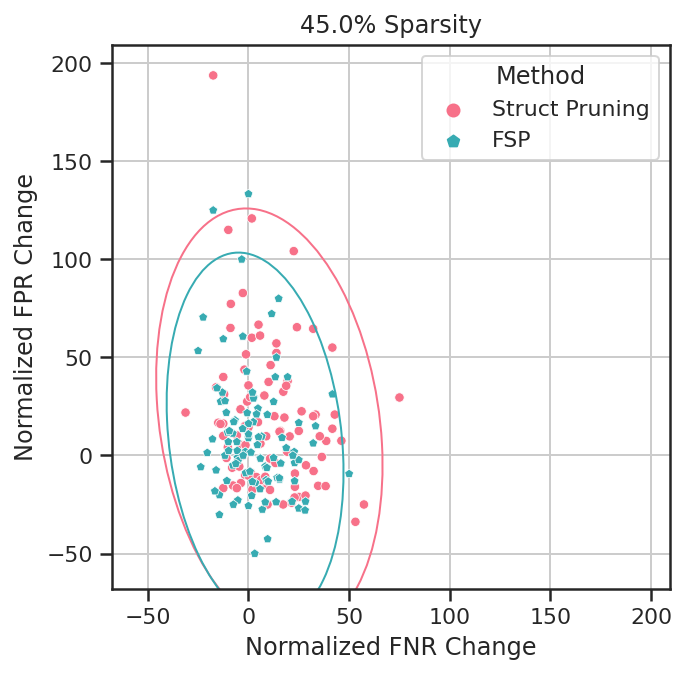

In [24]:
plot_dis(['Struct Pruning',  'FSP'], pruning_stats, 45.0, min_v, max_v)

(-52.38095238095239, 193.75000000000003)

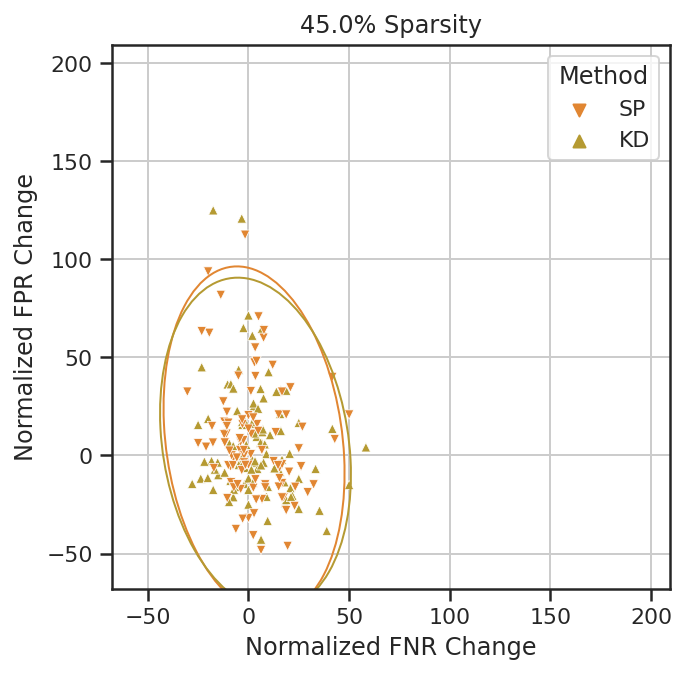

In [25]:
plot_dis(['KD', 'SP'], pruning_stats, 45.0, min_v, max_v)

(-52.38095238095239, 193.75000000000003)

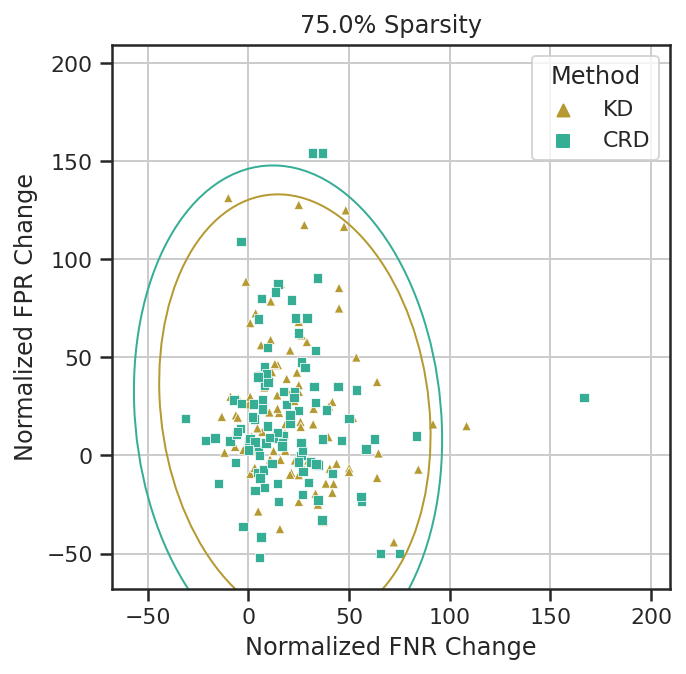

In [26]:
plot_dis(['KD', 'CRD'], pruning_stats, 75.0, min_v, max_v)

(-96.42857142857144, 362.49999999999994)

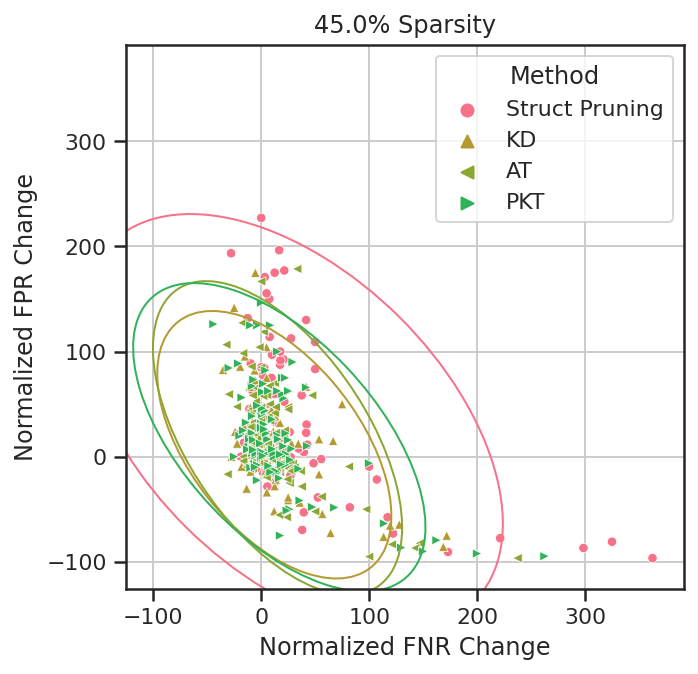

In [27]:
plot_dis(['Struct Pruning', 'KD', 'AT', 'PKT'], bias_pruning_stats, 45.0)

(-96.42857142857144, 362.49999999999994)

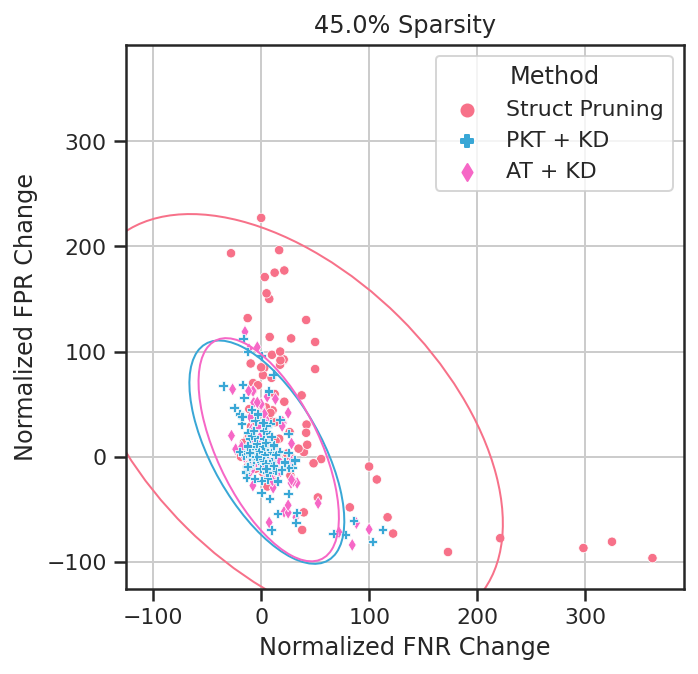

In [28]:
plot_dis(['Struct Pruning', 'AT + KD', 'PKT + KD'], bias_pruning_stats, 45.0)

In [29]:
bias_pruning_stats['method']

0     Struct Pruning
1     Struct Pruning
2     Struct Pruning
3     Struct Pruning
4                 SP
5                 SP
6                 SP
7                 SP
8            SP + KD
9            SP + KD
10           SP + KD
11           SP + KD
12                KD
13                KD
14                KD
15                KD
16                AT
17                AT
18                AT
19                AT
20           AT + KD
21           AT + KD
22           AT + KD
23           AT + KD
24               PKT
25               PKT
26               PKT
27               PKT
28          PKT + KD
29          PKT + KD
30          PKT + KD
31          PKT + KD
32               FSP
33               FSP
34               FSP
35               FSP
36          FSP + KD
37          FSP + KD
38          FSP + KD
39          FSP + KD
Name: method, dtype: object

(-50.0, 174.99999999999994)

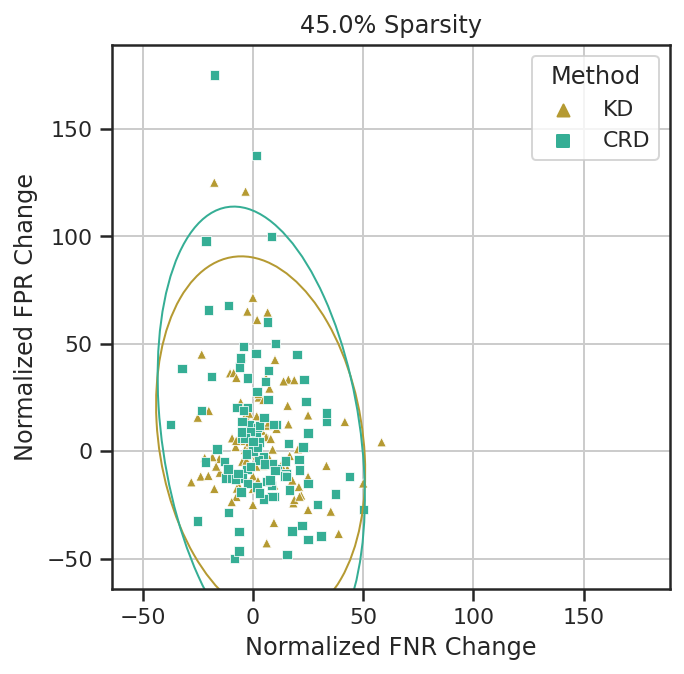

In [30]:
plot_dis(['KD', 'CRD'], pruning_stats, 45.0)

In [31]:
np.unique(pruning_stats['method'])

array(['AT', 'AT + KD', 'CRD', 'FSP', 'FSP + KD', 'KD', 'PKT', 'PKT + KD',
       'SP', 'SP + KD', 'Struct Pruning'], dtype=object)

(-50.0, 133.33333333333331)

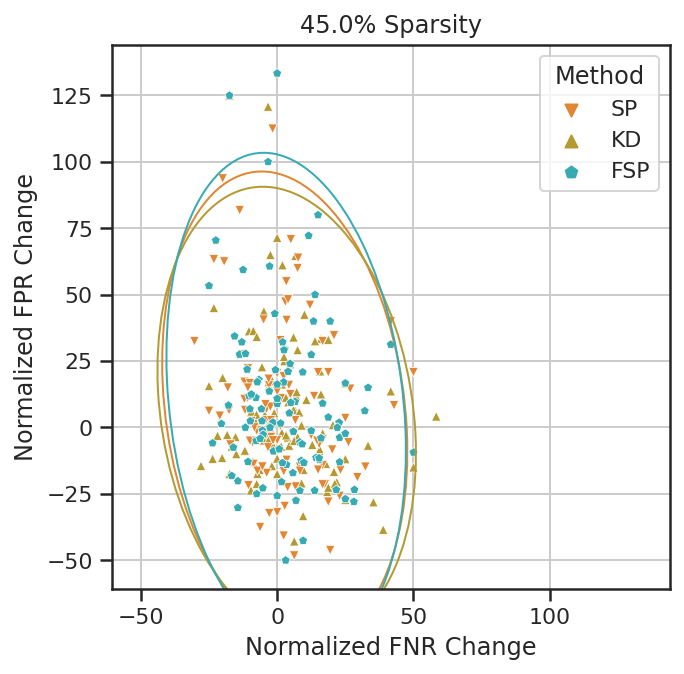

In [32]:
plot_dis(['KD', 'SP', 'FSP'], pruning_stats, 45.0)

In [33]:
sns.color_palette()

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

(-44.23076923076923, 193.75000000000003)

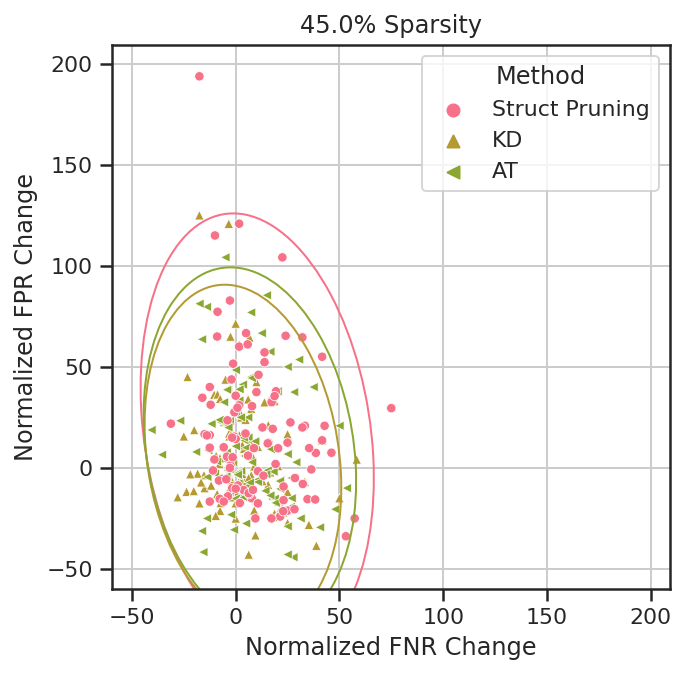

In [34]:
plot_dis(['KD', 'AT', 'Struct Pruning'], pruning_stats, 45.0)

(-51.92307692307693, 231.25)

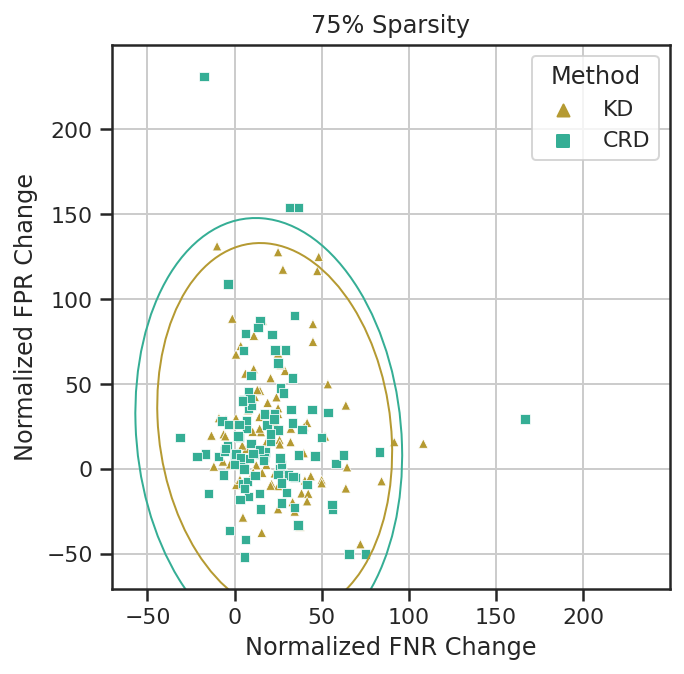

In [35]:
plot_dis(['KD', 'CRD'], pruning_stats, 75)

In [36]:
safe_stats = pruning_stats[[True if '+ KD' not in method else False for method in pruning_stats['method']]]

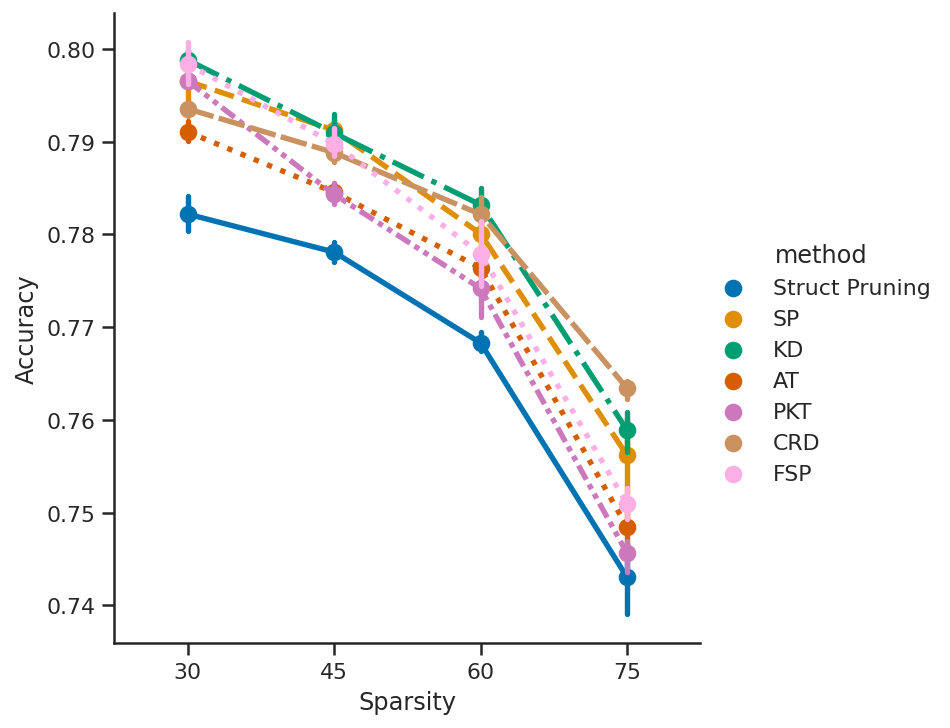

In [37]:
sns.catplot(x='Sparsity', y='Accuracy', hue='method', kind='point', 
                       data=safe_stats, linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})

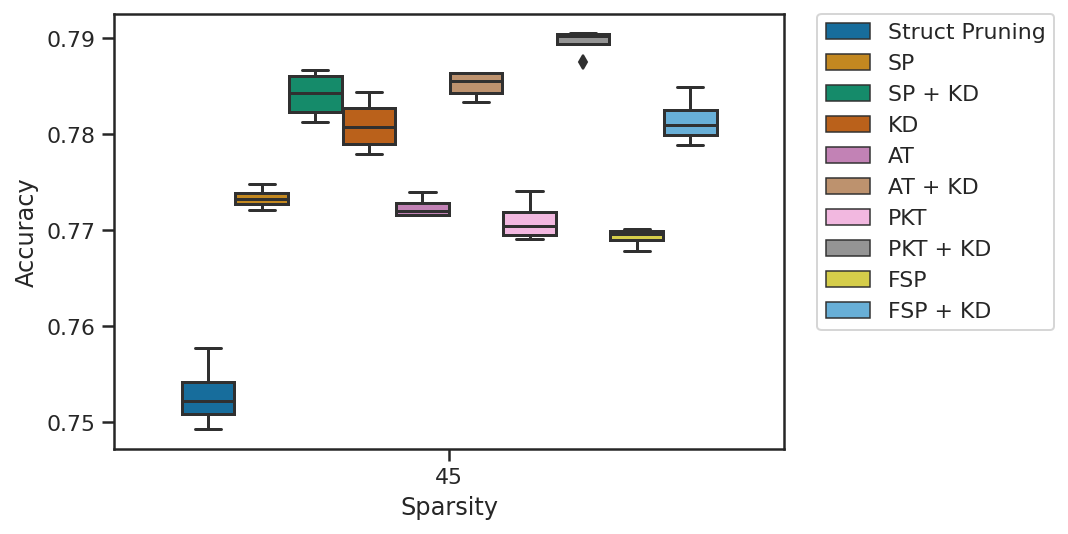

In [38]:
sns.boxplot(x='Sparsity', y='Accuracy', hue='method', 
                       data=bias_pruning_stats)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

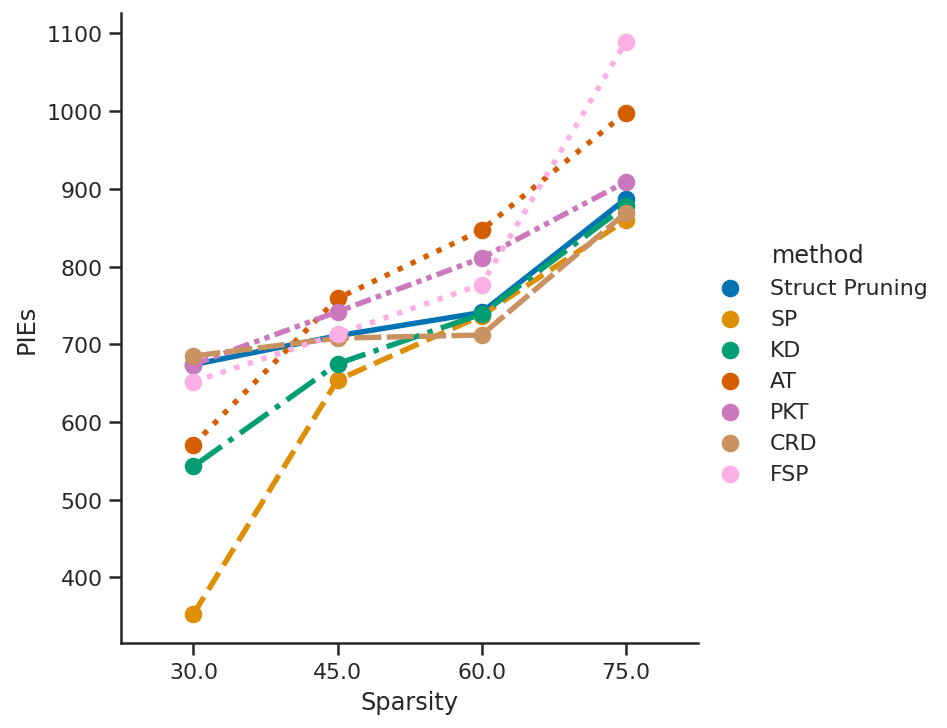

In [39]:
safe_pies = pies[[True if '+ KD' not in method else False for method in pies['method']]]
sns.catplot(x='Sparsity', y='PIEs', hue='method', kind='point', 
                       data=safe_pies, linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})


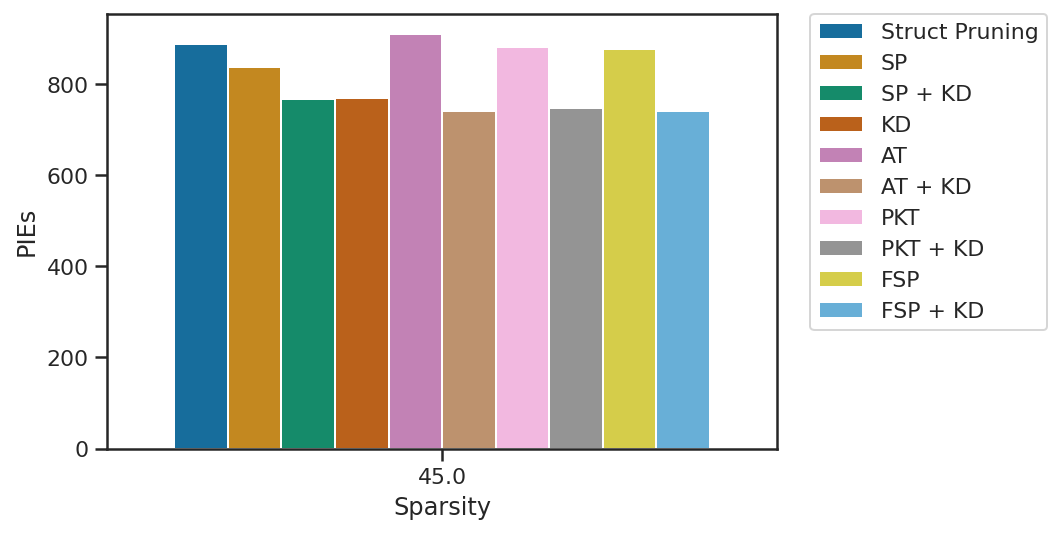

In [40]:
sns.barplot(x='Sparsity', y='PIEs', hue='method', 
                       data=bias_pies)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [41]:
prune_errors = np.array([return_compression_errors(pruning_stats, method, sparsity) for method, sparsity in list(zip(pies.method, pies.Sparsity))])
safe_prune_errors = np.array([return_compression_errors(pruning_stats, method, sparsity) for method, sparsity in list(zip(pies.method, safe_pies.Sparsity))])
bias_prune_errors = np.array([return_compression_errors(bias_pruning_stats, method, sparsity) for method, sparsity in list(zip(bias_pies.method, bias_pies.Sparsity))])

In [42]:
safe_pies = safe_pies.astype({'Sparsity': str})
pies = pies.astype({'Sparsity': str})

In [43]:
pies['Combined Error Varience'] = prune_errors[:,0]
pies["Symmetric Distance Error"] = prune_errors[:,1]
safe_pies['Combined Error Varience'] = safe_prune_errors[:,0]
safe_pies["Symmetric Distance Error"] = safe_prune_errors[:,1]
bias_pies['Combined Error Varience'] = bias_prune_errors[:,0]
bias_pies["Symmetric Distance Error"] = bias_prune_errors[:,1]

In [44]:
pies

,PIEs,method,Sparsity,block1,block2,block3,fc,Combined Error Varience,Symmetric Distance Error
0,674.0,Struct Pruning,30.0,0.110764,0.230935,0.554830,0.207340,636.024149,20.065370
1,711.0,Struct Pruning,45.0,0.125646,0.266176,0.574056,0.237335,822.523728,22.782845
2,741.0,Struct Pruning,60.0,0.168584,0.319266,0.602460,0.273138,906.577147,22.610559
3,887.0,Struct Pruning,75.0,0.226446,0.391265,0.630179,0.280004,1772.851372,33.422661
5,353.0,SP,30.0,0.074923,0.162626,0.445310,0.122220,466.295426,17.629536
6,654.0,SP,45.0,0.114779,0.239872,0.531588,0.169010,544.495866,19.336998
7,737.0,SP,60.0,0.160767,0.305387,0.581119,0.214629,735.662467,20.402938
8,860.0,SP,75.0,0.220938,0.385699,0.620270,0.229601,1075.915997,27.687141
10,543.0,KD,30.0,0.079326,0.178671,0.480058,0.125690,405.471054,15.931059
11,675.0,KD,45.0,0.108775,0.230964,0.538444,0.154494,518.718892,17.347689


In [45]:
# sns.catplot(data=pies, x='Sparsity', y="Symmetric Distance Error", hue='method', kind='point', linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
#                        scatter_kws={'s':1})

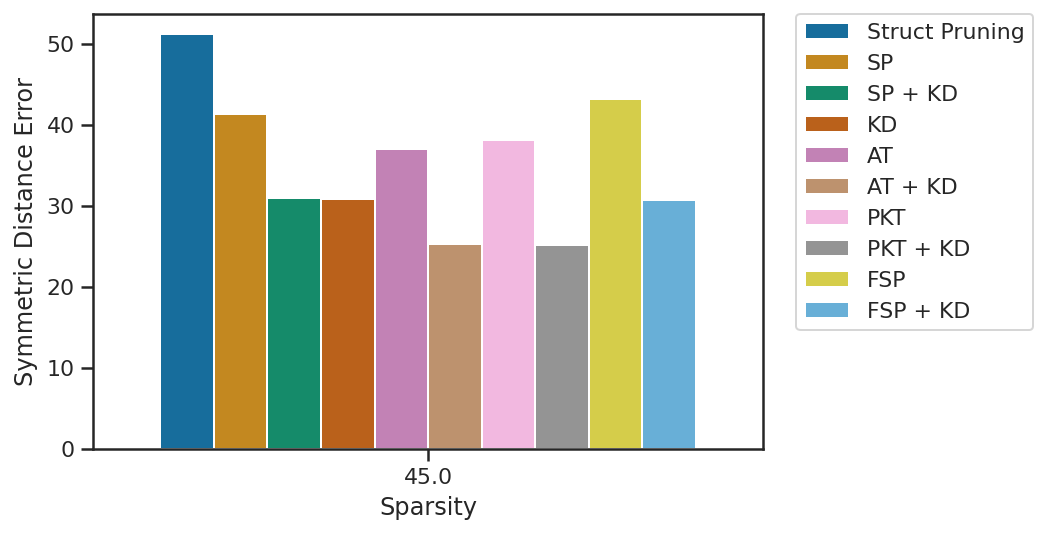

In [46]:
sns.barplot(data=bias_pies, x='Sparsity', y="Symmetric Distance Error", hue='method')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [47]:
# sns.catplot(data=pies, x='Sparsity', y='Combined Error Varience', hue='method', kind='point', linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
#                        scatter_kws={'s':1})

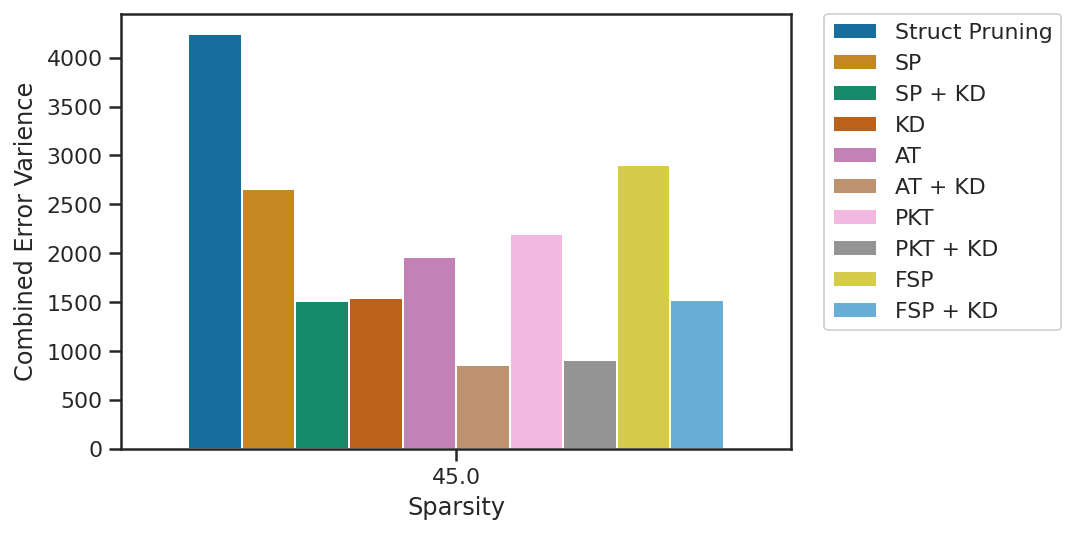

In [48]:
sns.barplot(data=bias_pies, x='Sparsity', y='Combined Error Varience', hue='method')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [73]:
pruning_stats['Sparsity'] == 45

0      False
1      False
2      False
3      False
4       True
       ...  
152     True
153     True
154     True
155     True
156     True
Name: Sparsity, Length: 131, dtype: bool

In [49]:
safe_pies

,PIEs,method,Sparsity,block1,block2,block3,fc,Combined Error Varience,Symmetric Distance Error
0,674.0,Struct Pruning,30.0,0.110764,0.230935,0.554830,0.207340,636.024149,20.065370
1,711.0,Struct Pruning,45.0,0.125646,0.266176,0.574056,0.237335,822.523728,22.782845
2,741.0,Struct Pruning,60.0,0.168584,0.319266,0.602460,0.273138,906.577147,22.610559
3,887.0,Struct Pruning,75.0,0.226446,0.391265,0.630179,0.280004,1772.851372,33.422661
5,353.0,SP,30.0,0.074923,0.162626,0.445310,0.122220,466.295426,17.629536
6,654.0,SP,45.0,0.114779,0.239872,0.531588,0.169010,544.495866,19.336998
7,737.0,SP,60.0,0.160767,0.305387,0.581119,0.214629,735.662467,20.402938
8,860.0,SP,75.0,0.220938,0.385699,0.620270,0.229601,1075.915997,27.687141
10,543.0,KD,30.0,0.079326,0.178671,0.480058,0.125690,405.471054,15.931059
11,675.0,KD,45.0,0.108775,0.230964,0.538444,0.154494,518.718892,17.347689


In [50]:
bias_pies

,PIEs,method,Sparsity,block1,block2,block3,fc,Combined Error Varience,Symmetric Distance Error
0,887.0,Struct Pruning,45.0,0.127235,0.267909,0.580583,0.260898,4237.391288,51.146442
1,838.0,SP,45.0,0.112922,0.239923,0.534529,0.187294,2654.846588,41.378314
2,768.0,SP + KD,45.0,0.107307,0.230820,0.537505,0.160958,1506.103290,30.973834
3,770.0,KD,45.0,0.106282,0.230044,0.540483,0.160435,1536.565697,30.788914
4,909.0,AT,45.0,0.044124,0.104296,0.474707,0.142481,1955.925732,37.000129
5,742.0,AT + KD,45.0,0.051103,0.121364,0.480447,0.122170,851.694399,25.246116
6,881.0,PKT,45.0,0.074941,0.166586,0.506399,0.153504,2190.690134,38.120664
7,748.0,PKT + KD,45.0,0.071161,0.164073,0.495360,0.127615,903.329042,25.103279
8,877.0,FSP,45.0,0.045392,0.162205,0.507827,0.171032,2901.940314,43.169059
9,742.0,FSP + KD,45.0,0.062631,0.186946,0.514077,0.156224,1518.462151,30.667565


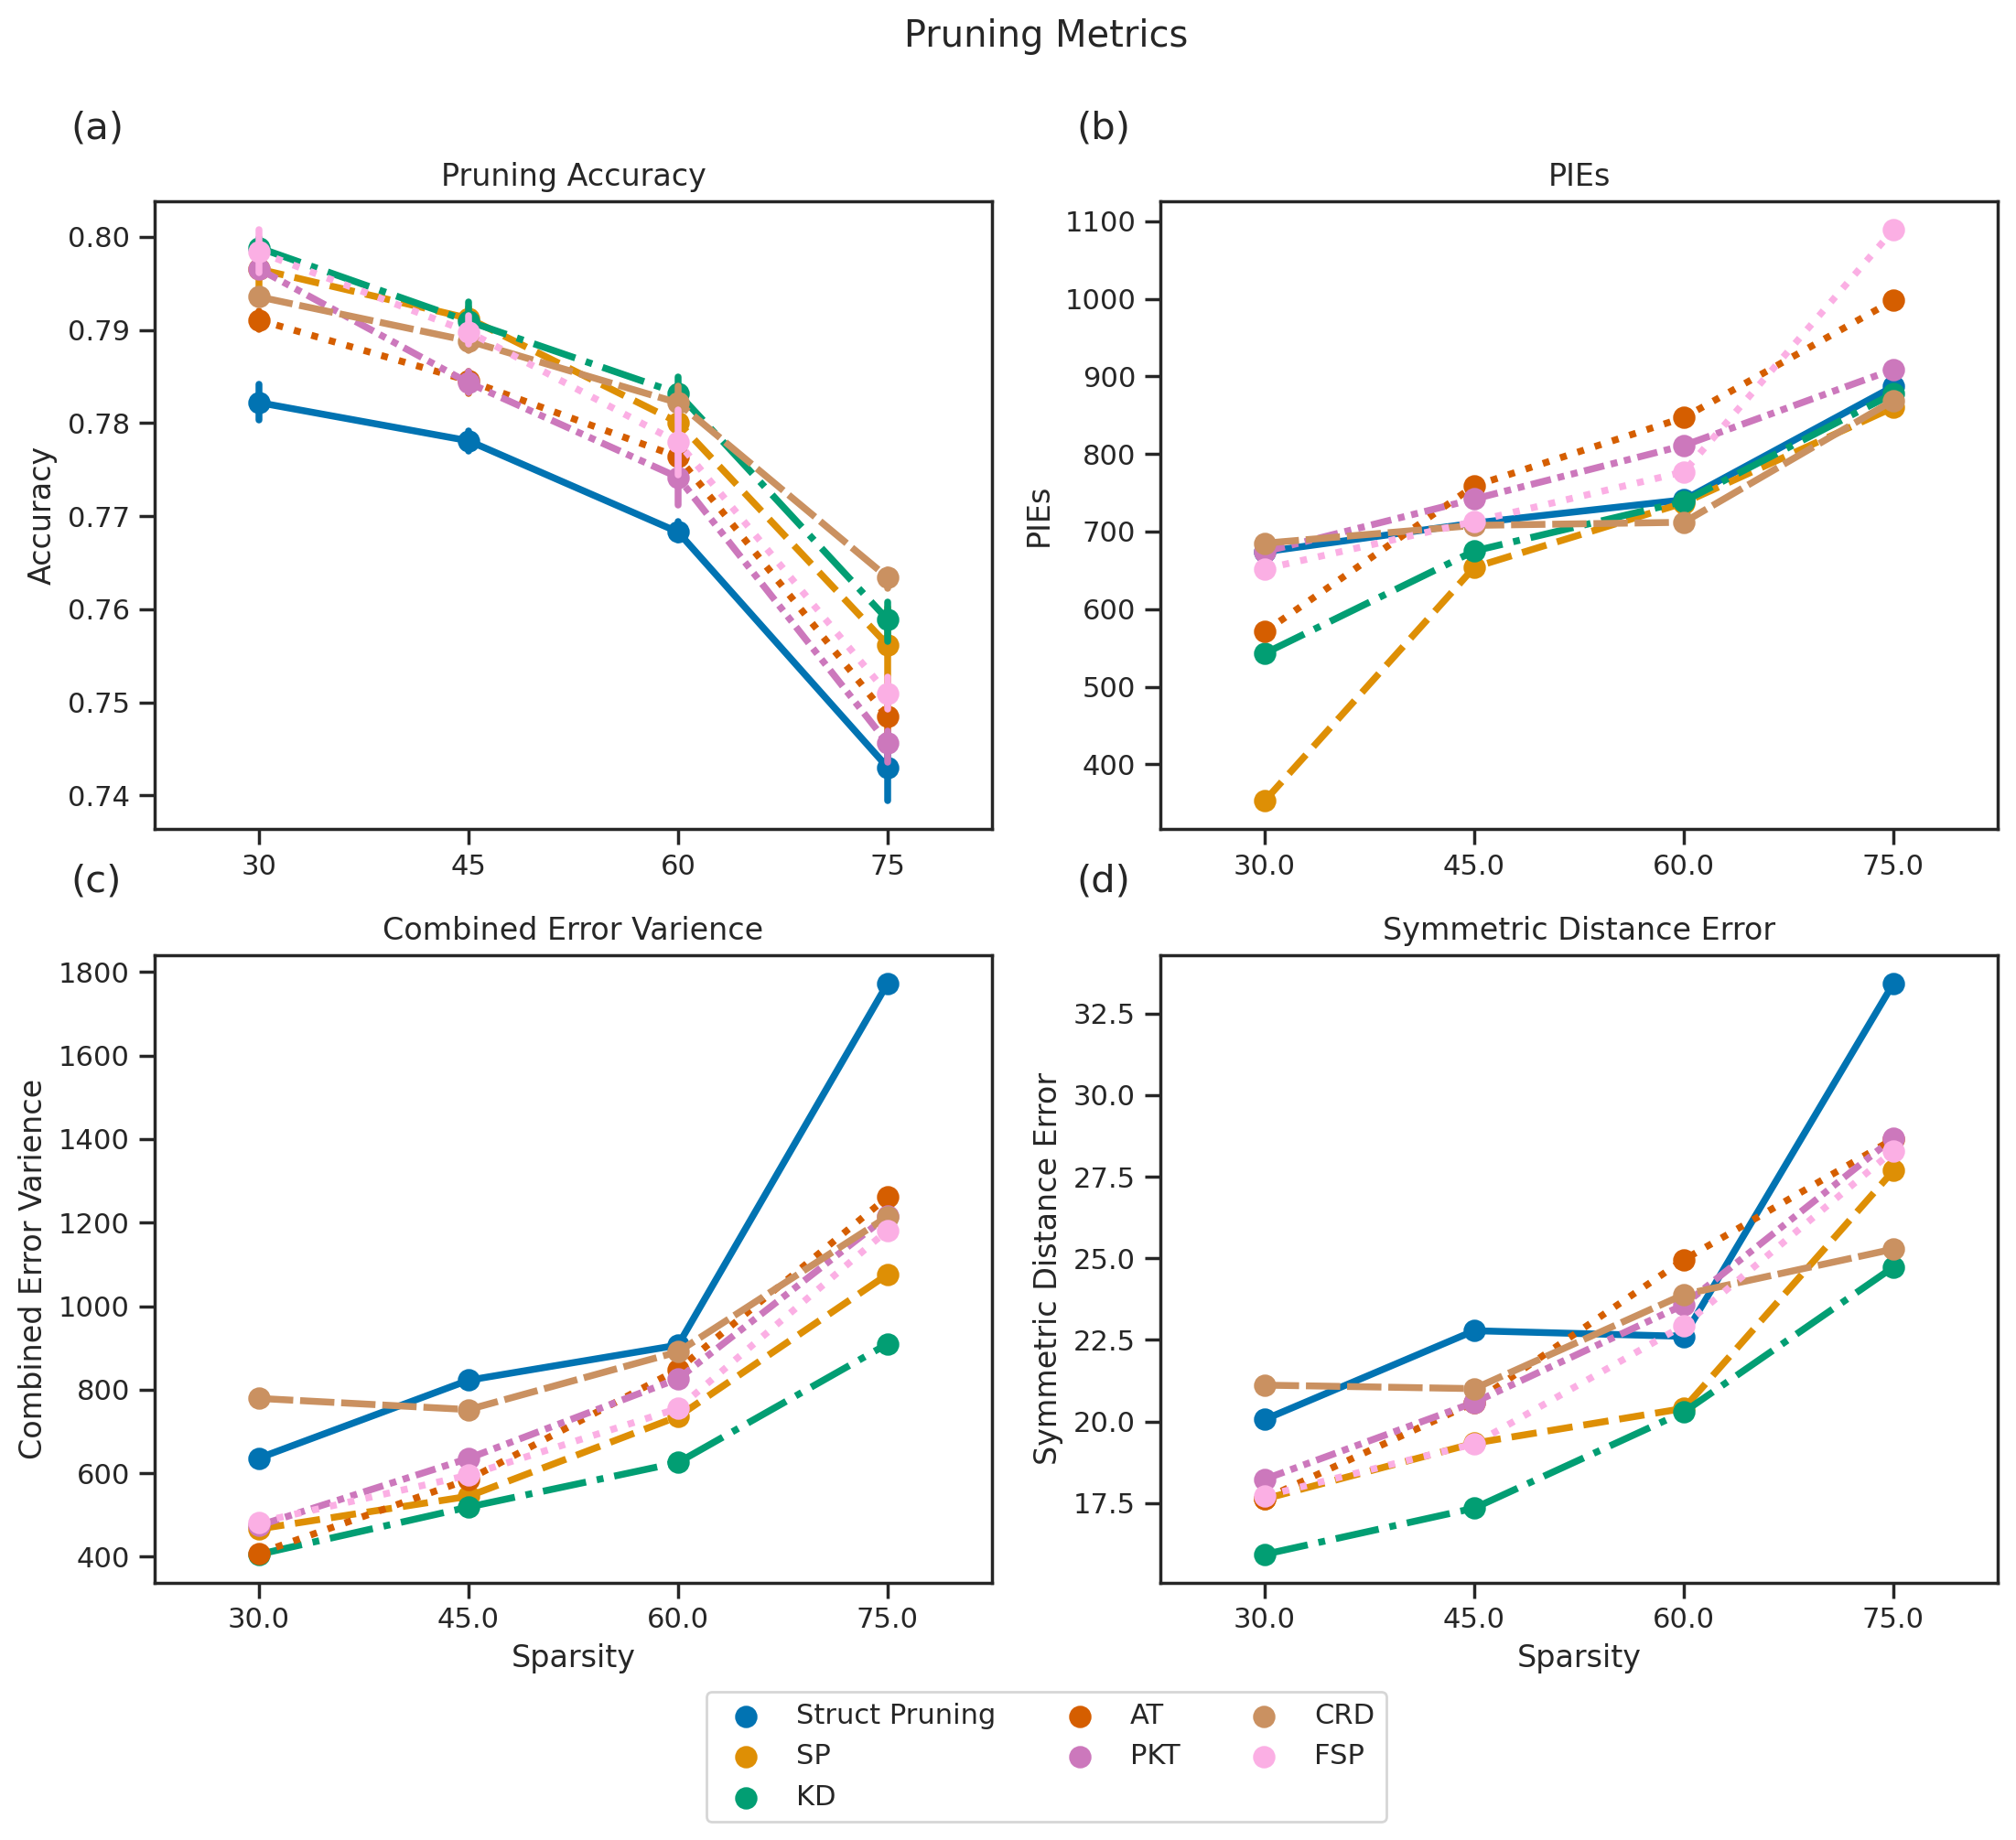

In [82]:
fig = plt.figure(figsize=(13, 10), dpi=100)

plt.subplot(2, 2, 1)
ax = sns.pointplot(x='Sparsity', y='Accuracy', hue='method', 
                       data=safe_stats, linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})

ax.get_legend().remove()
ax.set_xlabel('')
ax.text(-0.1, 1.1, '(a)', transform=ax.transAxes, 
        size=15)
plt.title("Pruning Accuracy")

plt.subplot(2, 2, 2)
ax = sns.pointplot(x='Sparsity', y='PIEs', hue='method', 
                       data=safe_pies, linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})
ax.get_legend().remove()
ax.set_xlabel('')
ax.text(-0.1, 1.1, '(b)', transform=ax.transAxes, 
        size=15)
plt.title("PIEs")

plt.subplot(2, 2, 3)
ax = sns.pointplot(data=safe_pies, x='Sparsity', y="Combined Error Varience", hue='method', linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})
ax.get_legend().remove()
ax.text(-0.1, 1.1, '(c)', transform=ax.transAxes, 
        size=15)
plt.title("Combined Error Varience")

plt.subplot(2, 2, 4)
ax = sns.pointplot(data=safe_pies, x='Sparsity', y="Symmetric Distance Error", hue='method', linestyles=line_styles[:len(methods)], marker=markers[:len(methods)],
                       scatter_kws={'s':1})

ax.get_legend().remove()
ax.text(-0.1, 1.1, '(d)', transform=ax.transAxes, 
        size=15)
plt.title("Symmetric Distance Error")

handles, labels = ax.get_legend_handles_labels()
lgd = fig.legend(handles, labels, loc='center', ncol=3, bbox_to_anchor=(.5, .03))

fig.suptitle('Pruning Metrics')
plt.savefig('Pruning_Metrics.png',  bbox_extra_artists=[lgd], bbox_inches='tight', transparent=False)
plt.show()


In [78]:
def get_delta_from_prune(df, method, sparsity):
        v = float(df[np.logical_and(df.method=='Struct Pruning', df.Sparsity==sparsity)]['Symmetric Distance Error'])
        m = float(df[np.logical_and(df.method==method, df.Sparsity==sparsity)]['Symmetric Distance Error'])
        sym_delta = m -v
        v = float(df[np.logical_and(df.method=='Struct Pruning', df.Sparsity==sparsity)]['Combined Error Varience'])
        m = float(df[np.logical_and(df.method==method, df.Sparsity==sparsity)]['Combined Error Varience'])
        cent_delta = m - v
        
        return cent_delta, sym_delta

In [117]:
no_struct = pies.drop(safe_pies[safe_pies.method == 'Struct Pruning'].index)

In [124]:
safe_pies = safe_pies.rename(columns={
                        "block1": "Block 1 SVCCA Distance",
                        "block2": "Block 2 SVCCA Distance",
                        "block3": "Block 3 SVCCA Distance",
                        "fc": "FC SVCCA Distance"
                    })

<AxesSubplot:xlabel='Block 1 SVCCA Distance', ylabel='Combined Error Varience'>

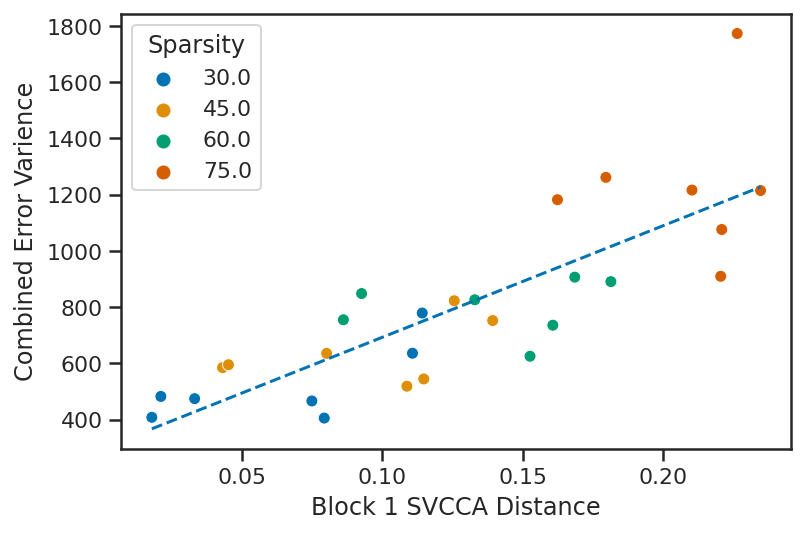

In [149]:
x = safe_pies['Block 1 SVCCA Distance'].to_numpy()
y = safe_pies["Combined Error Varience"].to_numpy()
m, b = np.polyfit(x, y, 1)
x_i = np.linspace(min(x), max(x), 10)
lines = plt.plot(x_i, m*x_i + b, linestyle='--')
sns.scatterplot(data=safe_pies, x='Block 1 SVCCA Distance', y="Combined Error Varience", hue='Sparsity')



<AxesSubplot:xlabel='Block 2 SVCCA Distance', ylabel='Combined Error Varience'>

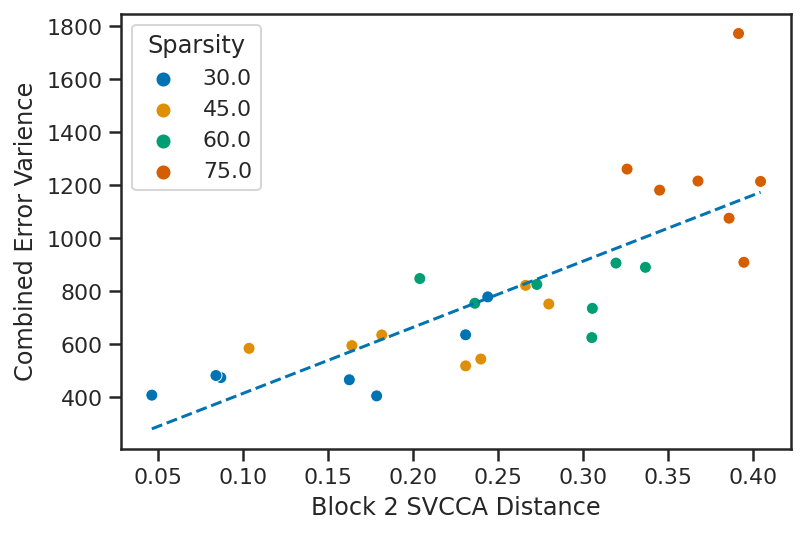

In [152]:
x = safe_pies['Block 2 SVCCA Distance'].to_numpy()
y = safe_pies["Combined Error Varience"].to_numpy()
m, b = np.polyfit(x, y, 1)
x_i = np.linspace(min(x), max(x), 10)
lines = plt.plot(x_i, m*x_i + b, linestyle='--')
sns.scatterplot(data=safe_pies, x='Block 2 SVCCA Distance', y="Combined Error Varience", hue='Sparsity')



<AxesSubplot:xlabel='Block 3 SVCCA Distance', ylabel='Combined Error Varience'>

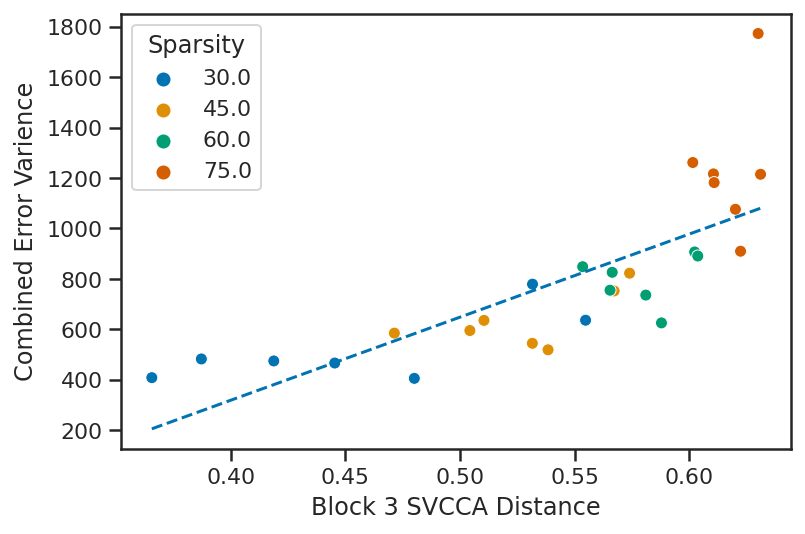

In [157]:
x = safe_pies['Block 3 SVCCA Distance'].to_numpy()
y = safe_pies["Combined Error Varience"].to_numpy()
m, b = np.polyfit(x, y, 1)
x_i = np.linspace(min(x), max(x), 10)
lines = plt.plot(x_i, m*x_i + b, linestyle='--')
sns.scatterplot(data=safe_pies, x='Block 3 SVCCA Distance', y="Combined Error Varience", hue='Sparsity')



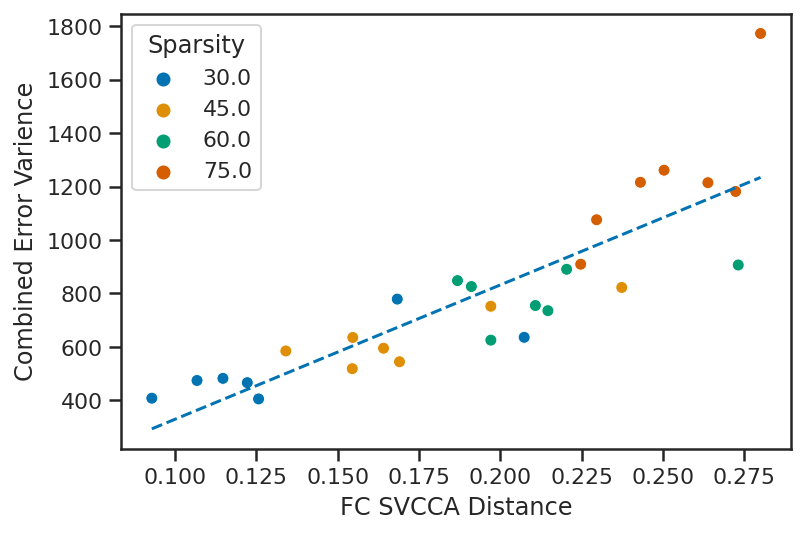

In [146]:
x = safe_pies["FC SVCCA Distance"].to_numpy()
y = safe_pies["Combined Error Varience"].to_numpy()
m, b = np.polyfit(x, y, 1)
x_i = np.linspace(min(x), max(x), 10)
lines = plt.plot(x_i, m*x_i + b, linestyle='--')
sns.scatterplot(data=safe_pies, x="FC SVCCA Distance", y="Combined Error Varience", hue='Sparsity')

In [77]:
printing = bias_pies.rename(columns={
                        "block1": "Block 1",
                        "block2": "Block 2",
                        "block3": "Block 3",
                        "fc": "FC",
                        'method': "Method"
                    })
printing = printing.drop(columns='Sparsity')
bias_prune_pring = bias_pruning_stats.rename(columns={'method': 'Method'})

In [78]:
printing

,PIEs,Method,Block 1,Block 2,Block 3,FC,Combined Error Varience,Symmetric Distance Error
0,887.0,Struct Pruning,0.127235,0.267909,0.580583,0.260898,4237.391288,51.146442
1,838.0,SP,0.112922,0.239923,0.534529,0.187294,2654.846588,41.378314
2,768.0,SP + KD,0.107307,0.230820,0.537505,0.160958,1506.103290,30.973834
3,770.0,KD,0.106282,0.230044,0.540483,0.160435,1536.565697,30.788914
4,909.0,AT,0.044124,0.104296,0.474707,0.142481,1955.925732,37.000129
5,742.0,AT + KD,0.051103,0.121364,0.480447,0.122170,851.694399,25.246116
6,881.0,PKT,0.074941,0.166586,0.506399,0.153504,2190.690134,38.120664
7,748.0,PKT + KD,0.071161,0.164073,0.495360,0.127615,903.329042,25.103279
8,877.0,FSP,0.045392,0.162205,0.507827,0.171032,2901.940314,43.169059
9,742.0,FSP + KD,0.062631,0.186946,0.514077,0.156224,1518.462151,30.667565


In [83]:
acc_l = []
for method in np.unique(bias_prune_pring['Method']):
    stats = bias_prune_pring[np.logical_and(bias_prune_pring.Method==method, bias_prune_pring.Sparsity==45.0)]
    acc_l.append(stats.Accuracy.mean() * 100)

printing['Accuracy'] = acc_l


In [85]:
with pd.option_context('display.float_format', '{:0.3f}'.format):
    print(printing.sort_values('Combined Error Varience').to_latex(index=False))

\begin{tabular}{rlrrrrrrr}
\toprule
   PIEs &         Method &  Block 1 &  Block 2 &  Block 3 &    FC &  Combined Error Varience &  Symmetric Distance Error &  Accuracy \\
\midrule
742.000 &        AT + KD &    0.051 &    0.121 &    0.480 & 0.122 &                  851.694 &                    25.246 &    77.100 \\
748.000 &       PKT + KD &    0.071 &    0.164 &    0.495 & 0.128 &                  903.329 &                    25.103 &    77.335 \\
768.000 &        SP + KD &    0.107 &    0.231 &    0.538 & 0.161 &                 1506.103 &                    30.974 &    76.927 \\
742.000 &       FSP + KD &    0.063 &    0.187 &    0.514 & 0.156 &                 1518.462 &                    30.668 &    75.285 \\
770.000 &             KD &    0.106 &    0.230 &    0.540 & 0.160 &                 1536.566 &                    30.789 &    78.142 \\
909.000 &             AT &    0.044 &    0.104 &    0.475 & 0.142 &                 1955.926 &                    37.000 &    78.097 \\
881

In [34]:
sns.scatterplot(data=pies, x='block1', y='Error Type Sym Dis', hue='sparsity')

ValueError: Could not interpret value `Error Type Sym Dis` for parameter `y`

In [35]:
sns.scatterplot(data=pies, x='block2', y='Error Type Sym Dis', hue='sparsity')

ValueError: Could not interpret value `Error Type Sym Dis` for parameter `y`

In [36]:
sns.scatterplot(data=pies, x='block3', y='Error Type Sym Dis', hue='sparsity')

ValueError: Could not interpret value `Error Type Sym Dis` for parameter `y`

In [37]:
pies = pies.dropna()

In [38]:
from scipy.stats import pearsonr

In [52]:
pies

,PIEs,method,Sparsity,block1,block2,block3,fc
0,674.0,Struct Pruning,30.0,0.110764,0.230935,0.554830,0.207340
1,711.0,Struct Pruning,45.0,0.125646,0.266176,0.574056,0.237335
2,741.0,Struct Pruning,60.0,0.168584,0.319266,0.602460,0.273138
3,887.0,Struct Pruning,75.0,0.226446,0.391265,0.630179,0.280004
5,353.0,SP,30.0,0.074923,0.162626,0.445310,0.122220
6,654.0,SP,45.0,0.114779,0.239872,0.531588,0.169010
7,737.0,SP,60.0,0.160767,0.305387,0.581119,0.214629
8,860.0,SP,75.0,0.220938,0.385699,0.620270,0.229601
10,543.0,KD,30.0,0.079326,0.178671,0.480058,0.125690
11,675.0,KD,45.0,0.108775,0.230964,0.538444,0.154494


In [68]:
pruning_stats.keys()

Index(['Accuracy', 'recall', 'f1-score', 'Sparsity', 'method', 'full_report',
       'false postives', 'false negatives', 'drift', 'FP_r', 'FN_r', 'Conf',
       'drift_mod'],
      dtype='object')

In [61]:
        indices = [
                (83, 'shrew', 0.1), (17, 'can', 0.2), (86, 'oak_tree', 0.2), (87, 'palm_tree', 0.2), 
                (76, 'dinosaur', 0.5), (20, 'apple', 0.1), (75, 'crocodile', 0.1), (22, 'orange', 0.5), 
                (58, 'elephant', 0.5), (94, 'train', 0.2), (63, 'raccoon', 0.5), (85, 'maple_tree', 0.1), 
                (90, 'bicycle', 0.1), (37, 'butterfly', 0.2), (6, 'flatfish', 0.5)]


In [62]:
sparse_45 = pruning_stats[pruning_stats.Sparsity == 45.0] 

In [111]:
def return_table_errors(df, bias_df, method, sparsity, indices):
    
    classes = 100
    
    # get method stats
    meth_stats = df[np.logical_and(df.method==method, df.Sparsity==sparsity)]
    
    conf_l = meth_stats.Conf
    acc_l = []
    for conf in conf_l:
        diag = np.diag(conf)
        FP = conf.sum(axis=0) - diag
        FN = conf.sum(axis=1) - diag
        TP = diag
        TN = conf.sum() - (FP + FN + TP)
    
        acc = TP + TN / (TP + TN + FP + FN)
        acc_l.append(acc)
        
    acc = np.mean(acc_l, axis=0)
    
    mean_FPR = meth_stats.FP_r.mean(axis=0)
    mean_FNR = meth_stats.FN_r.mean(axis=0)
    FPR_change = (mean_FPR - FPR_t)/FPR_t * 100
    FNR_change = (mean_FNR - FNR_t)/FNR_t * 100
    
    bias_meth_stats = bias_df[np.logical_and(bias_df.method==method, bias_df.Sparsity==sparsity)]
    bias_mean_FPR = bias_meth_stats.FP_r.mean(axis=0)
    bias_mean_FNR = bias_meth_stats.FN_r.mean(axis=0)
    bias_FPR_change = (bias_mean_FPR - FPR_t)/FPR_t * 100
    bias_FNR_change = (bias_mean_FNR - FNR_t)/FNR_t * 100
    
    bias_conf_l = bias_meth_stats.Conf
    bias_acc_l = []
    for bias_conf in bias_conf_l:
        bias_diag = np.diag(bias_conf)
        bias_FP = bias_conf.sum(axis=0) - bias_diag
        bias_FN = bias_conf.sum(axis=1) - bias_diag
        bias_TP = bias_diag
        bias_TN = bias_conf.sum() - (bias_FP + bias_FN + bias_TP)

        bias_acc = bias_TP + bias_TN / (bias_TP + bias_TN + bias_FP + bias_FN)
        bias_acc_l.append(bias_acc)
    
    bias_acc = np.mean(bias_acc_l, axis=0)
    

    classes = []
    
    
    for idx in indices:
        method_dict = {}
        method_dict['Class Name'] = idx[1].replace('_', ' ')
        method_dict['Percentage Remain'] = idx[2] * 100
        method_dict['Org'] = acc[idx[0]]
        method_dict['Bias'] = bias_acc[idx[0]]
        method_dict['Method'] = method
        classes.append(method_dict)

    return classes

In [112]:
first_meth = ["Struct Pruning","KD", "FSP", 'FSP + KD', 'SP']

In [113]:
np.unique(pruning_stats['method'])

array(['AT', 'AT + KD', 'CRD', 'FSP', 'FSP + KD', 'KD', 'PKT', 'PKT + KD',
       'SP', 'SP + KD', 'Struct Pruning'], dtype=object)

In [114]:
change_df = pd.DataFrame(list(itertools.chain(*[return_table_errors(pruning_stats, bias_pruning_stats, method, 45.0, indices) for method in first_meth])))

In [115]:
change_df = change_df.sort_values('Percentage Remain')

In [116]:
change_df

,Class Name,Percentage Remain,Org,Bias,Method
0,shrew,10.0,76.488000,29.989775,Struct Pruning
66,crocodile,10.0,92.489275,71.239925,SP
65,apple,10.0,91.488775,75.489700,SP
26,maple tree,10.0,87.238825,77.989725,KD
56,maple tree,10.0,89.988425,77.239750,FSP + KD
...,...,...,...,...,...
44,flatfish,50.0,86.488400,76.238725,FSP
49,dinosaur,50.0,91.739250,89.989275,FSP + KD
52,orange,50.0,81.738600,75.989250,FSP + KD
25,raccoon,50.0,77.988200,72.488475,KD


In [117]:
ax2 = ['Org', 'Bias']

In [118]:
def key_x (x):
    if np.in1d(x, first_meth).sum() > 0:
        return [first_meth.index(x_i) for x_i in x]
    else:
        return [ax2.index(x_i) for x_i in x]

In [119]:
piv = change_df.pivot(index=['Class Name', 'Percentage Remain'], columns='Method', values=['Org', 'Bias']).swaplevel(0, 1, axis=1).sort_index(axis=1, key=key_x).sort_values('Percentage Remain')

In [120]:
piv

Method                       Struct Pruning                    KD             \
                                        Org       Bias        Org       Bias   
Class Name Percentage Remain                                                   
apple      10.0                   88.738875  66.989675  91.238650  79.239575   
bicycle    10.0                   84.238000  33.239750  88.738375  62.239325   
crocodile  10.0                   92.488775  63.989950  92.489200  79.489800   
maple tree 10.0                   88.738600  55.989775  87.238825  77.989725   
shrew      10.0                   76.488000  29.989775  80.237875  45.489425   
butterfly  20.0                   83.237825  59.739025  84.237900  71.238950   
can        20.0                   89.738975  80.989650  88.489200  81.239550   
oak tree   20.0                   77.738375  63.739575  78.488700  70.739325   
palm tree  20.0                   88.237525  71.988825  90.237825  79.488750   
train      20.0                   95.489025  84.989275  94.739225  90.239100   
dinosaur   50.0                   92.738825  89.738900  92.739100  90.489300   
elephant   50.0                   92.238900  86.988925  89.739200  89.739325   
flatfish   50.0                   82.737900  74.489200  86.488500  80.988875   
orange     50.0                   81.487975  70.488775  82.488425  75.988825   
raccoon    50.0                   75.487950  62.738600  77.988200  72.488475   

Method                              FSP              FSP + KD             \
                                    Org       Bias        Org       Bias   
Class Name Percentage Remain                                               
apple      10.0               90.738775  72.989775  91.488600  78.739500   
bicycle    10.0               85.737875  37.739775  85.738425  58.239425   
crocodile  10.0               92.739300  71.989900  92.239200  79.489800   
maple tree 10.0               89.239075  63.489900  89.988425  77.239750   
shrew      10.0               78.738325  34.989700  74.988575  48.989475   
butterfly  20.0               82.988225  68.488875  85.238100  69.488700   
can        20.0               89.739050  80.489525  89.239275  82.739700   
oak tree   20.0               77.488150  65.489575  79.488550  68.739400   
palm tree  20.0               90.487700  77.988975  90.488000  80.238900   
train      20.0               94.238925  86.489250  95.989225  87.239325   
dinosaur   50.0               92.739100  88.989325  91.739250  89.989275   
elephant   50.0               93.489100  90.739150  91.989400  89.488975   
flatfish   50.0               86.488400  76.238725  86.488400  82.238725   
orange     50.0               78.238475  72.738800  81.738600  75.989250   
raccoon    50.0               77.988450  68.238700  78.988225  72.238450   

Method                               SP             
                                    Org       Bias  
Class Name Percentage Remain                        
apple      10.0               91.488775  75.489700  
bicycle    10.0               85.987975  42.739700  
crocodile  10.0               92.489275  71.239925  
maple tree 10.0               91.238675  63.739900  
shrew      10.0               75.738375  34.989775  
butterfly  20.0               83.988200  65.739225  
can        20.0               90.239300  81.239575  
oak tree   20.0               77.238450  68.489650  
palm tree  20.0               90.237550  77.488900  
train      20.0               94.989150  86.239325  
dinosaur   50.0               92.989225  90.239275  
elephant   50.0               91.739225  89.738950  
flatfish   50.0               85.988225  76.489200  
orange     50.0               82.488025  74.238875  
raccoon    50.0               79.488400  70.738725

In [121]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(piv.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
        & Method & \multicolumn{2}{l}{Struct Pruning} & \multicolumn{2}{l}{KD} & \multicolumn{2}{l}{FSP} & \multicolumn{2}{l}{FSP + KD} & \multicolumn{2}{l}{SP} \\
        & {} &            Org &  Bias &   Org &  Bias &   Org &  Bias &      Org &  Bias &   Org &  Bias \\
Class Name & Percentage Remain &                &       &       &       &       &       &          &       &       &       \\
\midrule
apple & 10.00 &          88.74 & 66.99 & 91.24 & 79.24 & 90.74 & 72.99 &    91.49 & 78.74 & 91.49 & 75.49 \\
bicycle & 10.00 &          84.24 & 33.24 & 88.74 & 62.24 & 85.74 & 37.74 &    85.74 & 58.24 & 85.99 & 42.74 \\
crocodile & 10.00 &          92.49 & 63.99 & 92.49 & 79.49 & 92.74 & 71.99 &    92.24 & 79.49 & 92.49 & 71.24 \\
maple tree & 10.00 &          88.74 & 55.99 & 87.24 & 77.99 & 89.24 & 63.49 &    89.99 & 77.24 & 91.24 & 63.74 \\
shrew & 10.00 &          76.49 & 29.99 & 80.24 & 45.49 & 78.74 & 34.99 &    74.99 & 48.99 & 75.74 & 34.99 \

In [122]:
dfs

In [133]:
all_df =  pd.DataFrame(list(itertools.chain(*[return_table_errors(pruning_stats, bias_pruning_stats, method, 45.0, indices) for method in np.unique(bias_pruning_stats['method'])])))

In [152]:
classes = [class_name for class_name in np.unique(all_df['Class Name'])]
min_class = [all_df[all_df['Class Name']==class_name]['Bias'].idxmin() for class_name in classes]
max_class = [all_df[all_df['Class Name']==class_name]['Bias'].idxmax() for class_name in classes]

In [150]:
min_class

[140, 147, 148, 31, 141, 79, 143, 149, 146, 137, 142, 138, 145, 135, 84]

In [153]:
for class_loc in max_class:
    print(all_df.loc[class_loc])

Class Name               apple
Percentage Remain         10.0
Org                   89.73865
Bias                 84.989475
Method                 AT + KD
Name: 20, dtype: object
Class Name             bicycle
Percentage Remain         10.0
Org                  88.238375
Bias                  69.48925
Method                PKT + KD
Name: 102, dtype: object
Class Name           butterfly
Percentage Remain         20.0
Org                     87.488
Bias                 77.238925
Method                 AT + KD
Name: 28, dtype: object
Class Name                 can
Percentage Remain         20.0
Org                  89.739225
Bias                 87.239275
Method                 AT + KD
Name: 16, dtype: object
Class Name           crocodile
Percentage Remain         10.0
Org                  92.989175
Bias                 86.239775
Method                 AT + KD
Name: 21, dtype: object
Class Name            dinosaur
Percentage Remain         50.0
Org                  92.739425
Bias       

In [124]:
first_meth = ["SP + KD","PKT", "PKT + KD", "AT", "AT + KD"]

In [125]:
change_df = pd.DataFrame(list(itertools.chain(*[return_table_errors(pruning_stats, bias_pruning_stats, method, 45.0, indices) for method in first_meth])))

In [126]:
np.unique(pruning_stats.method)

array(['AT', 'AT + KD', 'CRD', 'FSP', 'FSP + KD', 'KD', 'PKT', 'PKT + KD',
       'SP', 'SP + KD', 'Struct Pruning'], dtype=object)

In [127]:
np.unique(change_df[change_df['Percentage Remain'] == 50]['Class Name'])

array(['dinosaur', 'elephant', 'flatfish', 'orange', 'raccoon'],
      dtype=object)

In [129]:
piv = change_df.pivot(index=['Class Name', 'Percentage Remain'], columns='Method', values=['Org', 'Bias']).swaplevel(0, 1, axis=1).sort_index(axis=1, key=key_x).sort_values('Percentage Remain')

In [130]:

piv

Method                          SP + KD                   PKT             \
                                    Org       Bias        Org       Bias   
Class Name Percentage Remain                                               
apple      10.0               92.238675  79.239575  90.738800  79.989650   
bicycle    10.0               88.238350  60.739550  85.737800  49.989850   
crocodile  10.0               92.988950  81.239875  90.989100  71.989925   
maple tree 10.0               91.238800  75.739600  88.488575  65.989900   
shrew      10.0               76.988125  48.989475  79.488500  41.239675   
butterfly  20.0               84.238225  73.489100  86.987950  72.988800   
can        20.0               88.739400  83.489525  87.239400  81.739525   
oak tree   20.0               78.238625  70.739525  77.238450  69.239650   
palm tree  20.0               90.238050  80.988500  89.988100  77.489225   
train      20.0               95.489175  90.239125  93.989075  84.989250   
dinosaur   50.0               92.989275  91.489225  93.989050  88.489350   
elephant   50.0               89.989375  89.739150  91.988975  90.489125   
flatfish   50.0               85.988300  79.238900  84.488300  76.989150   
orange     50.0               81.738625  74.489100  85.488375  76.239025   
raccoon    50.0               77.738275  74.238825  79.238000  72.488425   

Method                         PKT + KD                    AT             \
                                    Org       Bias        Org       Bias   
Class Name Percentage Remain                                               
apple      10.0               90.489000  83.989475  89.738800  81.239700   
bicycle    10.0               88.238375  69.489250  87.237950  59.739750   
crocodile  10.0               92.489200  84.739725  90.989200  73.989950   
maple tree 10.0               88.738275  82.489625  87.488800  72.989950   
shrew      10.0               80.738575  54.739375  73.987950  43.489600   
butterfly  20.0               87.237775  75.738925  88.737550  72.488900   
can        20.0               86.989300  85.989650  89.489275  83.239350   
oak tree   20.0               78.238550  71.489575  75.738475  69.489375   
palm tree  20.0               89.987925  83.988575  90.738150  81.738925   
train      20.0               95.489275  90.489225  96.239050  86.489275   
dinosaur   50.0               92.739425  92.739325  92.739275  90.739125   
elephant   50.0               92.989325  91.989275  92.239025  89.489050   
flatfish   50.0               84.238525  80.488975  81.488325  76.988725   
orange     50.0               84.238600  77.989075  84.238625  76.239150   
raccoon    50.0               78.238175  74.738250  75.237900  68.238325   

Method                          AT + KD             
                                    Org       Bias  
Class Name Percentage Remain                        
apple      10.0               89.738650  84.989475  
bicycle    10.0               86.988000  68.989300  
crocodile  10.0               92.989175  86.239775  
maple tree 10.0               88.988425  82.489575  
shrew      10.0               81.238025  56.239325  
butterfly  20.0               87.488000  77.238925  
can        20.0               89.739225  87.239275  
oak tree   20.0               77.238625  71.989475  
palm tree  20.0               88.237800  84.988675  
train      20.0               93.739350  90.739375  
dinosaur   50.0               93.739300  91.739350  
elephant   50.0               90.989275  90.989225  
flatfish   50.0               82.488325  76.738725  
orange     50.0               84.238625  76.739050  
raccoon    50.0               78.987875  73.737925

In [131]:
with pd.option_context('display.float_format', '{:0.2f}'.format):
    print(piv.to_latex())

\begin{tabular}{llrrrrrrrrrr}
\toprule
        & Method & \multicolumn{2}{l}{SP + KD} & \multicolumn{2}{l}{PKT} & \multicolumn{2}{l}{PKT + KD} & \multicolumn{2}{l}{AT} & \multicolumn{2}{l}{AT + KD} \\
        & {} &     Org &  Bias &   Org &  Bias &      Org &  Bias &   Org &  Bias &     Org &  Bias \\
Class Name & Percentage Remain &         &       &       &       &          &       &       &       &         &       \\
\midrule
apple & 10.00 &   92.24 & 79.24 & 90.74 & 79.99 &    90.49 & 83.99 & 89.74 & 81.24 &   89.74 & 84.99 \\
bicycle & 10.00 &   88.24 & 60.74 & 85.74 & 49.99 &    88.24 & 69.49 & 87.24 & 59.74 &   86.99 & 68.99 \\
crocodile & 10.00 &   92.99 & 81.24 & 90.99 & 71.99 &    92.49 & 84.74 & 90.99 & 73.99 &   92.99 & 86.24 \\
maple tree & 10.00 &   91.24 & 75.74 & 88.49 & 65.99 &    88.74 & 82.49 & 87.49 & 72.99 &   88.99 & 82.49 \\
shrew & 10.00 &   76.99 & 48.99 & 79.49 & 41.24 &    80.74 & 54.74 & 73.99 & 43.49 &   81.24 & 56.24 \\
butterfly & 20.00 &   84.24 & 73.49